# ERV Calculation
- Author: Hamid Ali Syed

In [1]:
import os
import glob
import pyart
import numpy as np
import xarray as xr
import pandas as pd
import pyscancf as pcf
import cartopy.crs as ccrs
from skimage import measure
import cartopy.feature as feat
from datetime import datetime
import matplotlib.pyplot as plt
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter, median_filter


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## Cite PyScanCf:

## Syed, H. A.,Sayyed, I., Kalapureddy, M. C. R., & Grandhi, K. K.(2021). 
## PyScanCf – The library for individual sweep datasets of IMD weather radars. 
## Zenodo. doi:10.5281/zenodo.5574160.



In [2]:
# Check if map_features.py does not exist
if not os.path.exists("map_features.py"):
    url = "https://raw.githubusercontent.com/syedhamidali/test_scripts/master/map_features.py"
    urllib.request.urlretrieve(url, "map_features.py")

import map_features as mf

In [3]:
filename = '/Users/syed44/Downloads/Others/Git_Stuff/imd_temp_radar/out/grid_GOA210516024101-IMD-B.nc'

In [12]:
grid = pyart.io.read_grid(filename).to_xarray()
grid = grid.where((grid.REF > -20) & (grid.REF < 100)).isel(z=8).squeeze()

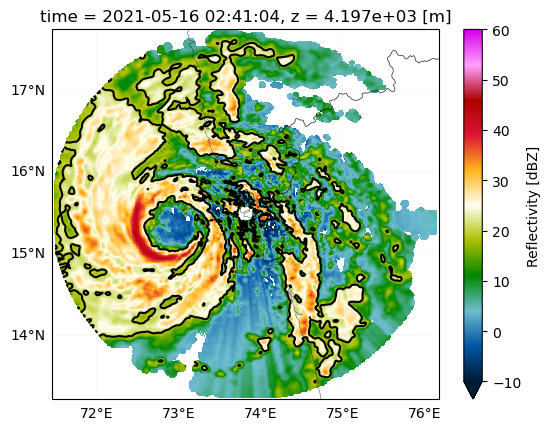

In [20]:
ax = plt.axes(projection=ccrs.PlateCarree())
grid['REF'].plot(x='lon', y='lat', cmap='SyedSpectral', vmin=-10, vmax=60, ax=ax)
grid['REF'].plot.contour(x='lon', y='lat', levels=[20,], colors='k', ax=ax)
mf.map_features(ax=ax, b=1, l=1)

In [25]:
def read_and_preprocess(filename):
    """
    Read the radar data from a NetCDF file and preprocess it.
    
    Parameters:
    filename (str): Path to the NetCDF file.
    
    Returns:
    xarray.Dataset: Preprocessed radar data.
    """
    grid = pyart.io.read_grid(filename).to_xarray()
    grid = grid.where((grid.REF > -20) & (grid.REF < 100)).isel(z=8)
    return grid

def find_nearest_grid_point(lon, lat, eye_center_lon, eye_center_lat):
    """
    Find the nearest grid point to the given latitude and longitude.
    
    Parameters:
    lon (numpy.ndarray): Longitude coordinates.
    lat (numpy.ndarray): Latitude coordinates.
    eye_center_lon (float): Longitude of the eye center.
    eye_center_lat (float): Latitude of the eye center.
    
    Returns:
    tuple: Indices of the nearest grid point.
    """
    distance = np.sqrt((lon - eye_center_lon) ** 2 + (lat - eye_center_lat) ** 2)
    nearest_idx = np.unravel_index(np.argmin(distance), distance.shape)
    return nearest_idx

def detect_contour(reflectivity, ref_contour, lon, lat, eye_center_lon, eye_center_lat):
    """
    Detect the specified contour and find the contour closest to the identified eye point.
    
    Parameters:
    reflectivity (numpy.ndarray): Reflectivity data.
    ref_contour (float): Reflectivity value to use for contour detection.
    lon (numpy.ndarray): Longitude coordinates.
    lat (numpy.ndarray): Latitude coordinates.
    eye_center_lon (float): Longitude of the eye center.
    eye_center_lat (float): Latitude of the eye center.
    
    Returns:
    numpy.ndarray: The best contour found.
    """
    reflectivity = median_filter(reflectivity, size=10)
    contours = measure.find_contours(reflectivity, level=ref_contour)
    min_dist = np.inf
    best_contour = None
    for contour in contours:
        dist = np.min(np.sqrt((lon[contour[:, 0].astype(int), 
                                   contour[:, 1].astype(int)] - eye_center_lon) ** 2 +
                              (lat[contour[:, 0].astype(int),
                                   contour[:, 1].astype(int)] - eye_center_lat) ** 2))
        if dist < min_dist:
            min_dist = dist
            best_contour = contour
    return best_contour

def fit_ellipse_and_calculate_erv(best_contour, reflectivity):
    """
    Fit an ellipse to the eye contour using EllipseModel and calculate the Eye Roundness Value (ERV).
    
    Parameters:
    best_contour (numpy.ndarray): The best contour found.
    reflectivity (numpy.ndarray): Reflectivity data.
    
    Returns:
    dict: Ellipse parameters and calculated ERV.
    """
    ellipse_params = None
    erv = None
    if best_contour is not None:
        y, x = best_contour.T
        ellipse_model = EllipseModel()
        if ellipse_model.estimate(np.column_stack([x, y])):
            xc, yc, a, b, theta = ellipse_model.params

            a *= 1.0  # already in meters
            b *= 1.0  # already in meters

            erv = np.sqrt(1 - (b/a)**2)
            print(f"Eye Roundness Value (ERV): {erv}")
            
            ellipse_params = {
                'xc': xc,
                'yc': yc,
                'a': a,
                'b': b,
                'theta': theta,
                'erv': erv
            }
        else:
            print("Ellipse fitting failed.")
    else:
        print("No suitable contour found.")
    return ellipse_params

def detect_eye(filename, eye_center_lat=15.2, eye_center_lon=73, ref_contour=20):
    """
    Detect the eye of the cyclone around the given lat and lon in the dataset and fit an
    ellipse to the nearest ref_contour dBZ contour.
    
    Parameters:
    filename (str): Path to the NetCDF file.
    eye_center_lat (float): Latitude of the eye center.
    eye_center_lon (float): Longitude of the eye center.
    ref_contour (float): Reflectivity value to use for contour detection.
    
    Returns:
    xarray.Dataset: Dataset with ellipse parameters and calculated Eye Roundness Value (ERV).
    """
    grid = read_and_preprocess(filename)
    reflectivity = grid['REF'].isel(time=0).values
    lon = grid['lon'].values
    lat = grid['lat'].values

    nearest_idx = find_nearest_grid_point(lon, lat, eye_center_lon, eye_center_lat)
    best_contour = detect_contour(reflectivity, ref_contour, lon, lat, 
                                  eye_center_lon, eye_center_lat)
    ellipse_params = fit_ellipse_and_calculate_erv(best_contour, reflectivity)

    if ellipse_params:
        contour_x = best_contour[:, 1]
        contour_y = best_contour[:, 0]
        contour_lon = lon[contour_y.astype(int), contour_x.astype(int)]
        contour_lat = lat[contour_y.astype(int), contour_x.astype(int)]
        
        contour_mask = np.zeros_like(reflectivity)
        ellipse_mask = np.zeros_like(reflectivity)
        
        for cx, cy in zip(contour_x.astype(int), contour_y.astype(int)):
            if 0 <= cx < contour_mask.shape[1] and 0 <= cy < contour_mask.shape[0]:
                contour_mask[cy, cx] = 1
        
        xc, yc, a, b, theta = ellipse_params['xc'], ellipse_params['yc'], ellipse_params['a'], ellipse_params['b'], ellipse_params['theta']
        yy, xx = np.ogrid[:ellipse_mask.shape[0], :ellipse_mask.shape[1]]
        ellipse_mask += ((xx - xc) * np.cos(theta) + (yy - yc) * np.sin(theta))**2 / a**2 + ((xx - xc) * np.sin(theta) - (yy - yc) * np.cos(theta))**2 / b**2 <= 1
        
        grid['contours'] = (('y', 'x'), contour_mask)
        grid['ellipses'] = (('y', 'x'), ellipse_mask)
        
        grid.attrs.update({
            'ellipse_xc': ellipse_params['xc'],
            'ellipse_yc': ellipse_params['yc'],
            'ellipse_a': ellipse_params['a'],
            'ellipse_b': ellipse_params['b'],
            'ellipse_theta': ellipse_params['theta'],
            'ellipse_erv': ellipse_params['erv']
        })
    else:
        grid['contours'] = (('y', 'x'), np.zeros_like(reflectivity))
        grid['ellipses'] = (('y', 'x'), np.zeros_like(reflectivity))

    return grid

def plot_eye_detection(ds, projection='geo'):
    """
    Plot the radar reflectivity data with detected eye contours and ellipses.
    
    Parameters:
    ds (xarray.Dataset): The radar data with added contours and ellipses.
    """
    if projection == 'geo':
        x_coord, y_coord = 'lon', 'lat'
    if projection == 'cartesian':
        x_coord, y_coord = 'x', 'y'

    fig, ax = plt.subplots()
    ds['REF'].plot(cmap='Grays', vmin=-10, vmax=60, ax=ax, x=x_coord, y=y_coord, alpha=0.5)
    
    contours = ds['contours'].values
    ellipses = ds['ellipses'].values
    
    ax.contour(ds[x_coord], ds[y_coord], contours, levels=[0.5], colors='c', label='contour')
    ax.contour(ds[x_coord], ds[y_coord], ellipses, levels=[0.5], colors='k', label='ellipse')
    
#     if 'ellipse_xc' in ds.attrs:
#         xc, yc, a, b, theta = ds.attrs['ellipse_xc'], ds.attrs['ellipse_yc'], ds.attrs['ellipse_a'], ds.attrs['ellipse_b'], ds.attrs['ellipse_theta']
#         ellipse_patch = Ellipse((xc, yc), 2*a, 2*b, angle=np.degrees(theta), edgecolor='red', facecolor='none', lw=2)
#         ax.add_patch(ellipse_patch)
    
    ax.set_title('Hurricane Eye Detection')
    plt.show()

In [26]:
def calculate_erv(ds):
    """
    Calculate the Eye Roundness Value (ERV) for a given dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the radar data with ellipses.

    Returns:
    pd.DataFrame: A DataFrame containing the major diameter, minor diameter, semi-major axis, semi-minor axis, and ERV.
    """
    # Select the ellipses
    ellip = ds.where(ds.ellipses != 0, drop=True).squeeze()

    # Calculate the major and minor diameters in kilometers
    major_dia = np.round((ellip['x'].max() - ellip['x'].min()).values / 1000, 2)
    minor_dia = np.round((ellip['y'].max() - ellip['y'].min()).values / 1000, 2)

    print(f"Major Diameter: {major_dia} km")
    print(f"Minor Diameter: {minor_dia} km")

    # Calculate the semi-major and semi-minor axes in kilometers
    a = major_dia / 2
    b = minor_dia / 2

    # Calculate the Eye Roundness Value (ERV)
    erv = np.sqrt(1 - (b/a)**2)
    erv = round(erv, 2)
    print(f"Eye Roundness Value (ERV): {erv}")

    # Create a DataFrame with the results
    data = {
        'Major Diameter (km)': [major_dia],
        'Minor Diameter (km)': [minor_dia],
        'Semi-major Axis (km)': [a],
        'Semi-minor Axis (km)': [b],
        'ERV': [erv]
    }
    df = pd.DataFrame(data)

    return df

Eye Roundness Value (ERV): 0.5071185351075012


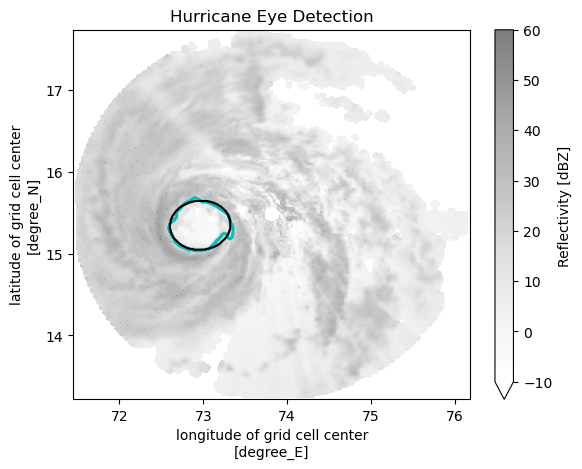

Major Diameter: 76.15 km
Minor Diameter: 65.13 km
Eye Roundness Value (ERV): 0.52


,Major Diameter (km),Minor Diameter (km),Semi-major Axis (km),Semi-minor Axis (km),ERV
0,76.15,65.13,38.075,32.565,0.52


In [27]:
# Usage
eye_center_lat = 15.2
eye_center_lon = 73
ref_contour = 19

ds = detect_eye(filename, eye_center_lat, eye_center_lon, ref_contour)
plot_eye_detection(ds)
# Example usage
df = calculate_erv(ds)
display(df)